Questions: 
* Should I include a pop. nreplies and ratio_replied?
* Since sample size is so small (esp for indigenous), is there a way to get the relative frequency of words? 
* Fix histograms

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import spacy 
from sklearn.utils import resample
from collections import Counter
import re
import transformers
import logging
from pysentimiento import EmotionAnalyzer
from pysentimiento.preprocessing import preprocess_tweet
transformers.logging.get_verbosity = lambda: logging.NOTSET
from scipy.stats import norm

## Replies preprocessing

In [3]:
dfs_r = []

for dataset in os.listdir('reply_datasets'):
    if dataset != '.ipynb_checkpoints':
        df = pd.read_csv('reply_datasets/'+dataset)
        dfs_r.append(df)

    
replies_all = pd.concat(dfs_r, axis=0, ignore_index=True)

In [4]:
replies_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2782 entries, 0 to 2781
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       2774 non-null   float64
 1   race             2782 non-null   object 
 2   conversation_id  2782 non-null   object 
 3   tweet            2782 non-null   object 
dtypes: float64(1), object(3)
memory usage: 87.1+ KB


In [5]:
replies_all.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
replies_all['race'] = replies_all['race'].apply(lambda x: x.strip('"'))
replies_all = replies_all.drop_duplicates()

In [7]:
replies_all_dup = replies_all[replies_all.duplicated() == True]

In [8]:
print(replies_all.info())
print(replies_all_dup.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 688 entries, 0 to 2781
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   race             688 non-null    object
 1   conversation_id  688 non-null    object
 2   tweet            688 non-null    object
dtypes: object(3)
memory usage: 21.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   race             0 non-null      object
 1   conversation_id  0 non-null      object
 2   tweet            0 non-null      object
dtypes: object(3)
memory usage: 0.0+ bytes
None


In [9]:
replies_all_dup['tweet'].value_counts()

Series([], Name: tweet, dtype: int64)

In [10]:
replies_all['race'].value_counts()

W    550
B    108
I     30
Name: race, dtype: int64

## Verified Preprocessing

In [11]:
# columns that I may need for analysis
verified_keep = ['id', 'conversation_id', 'created_at', 'date', 'timezone',
       'place', 'tweet', 'language', 'hashtags', 'user_id', 'username', 'name', 'retweet', 'nlikes', 'nreplies',
       'nretweets', 'near', 'geo', 'source', 'reply_to','race']

Already ran below code to fix one dataset I had to get using the CLI instead

```python
chrs_df = pd.read_csv('chris_tweets.csv', sep='\t')
chrs_df.info()
```

```python
chrs_df.rename({'replies_count': 'nreplies', 'retweets_count': 'nretweets', 'like_count': 'nlikes'})
chrs_df = chrs_df.drop([c for c in chrs_df.columns if c not in verified_keep], axis=1)
```

```python
chrs_df.to_csv('chris_verified.csv')
```

In [12]:
dfs_v = []

for dataset in os.listdir('verified_datasets'):
    f, ext = os.path.splitext(dataset)
    if ext == '.csv':
        df = pd.read_csv('verified_datasets/'+dataset)
        dfs_v.append(df)

    
verified_all = pd.concat(dfs_v, axis=0, ignore_index=True)

In [13]:
verified_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       470 non-null    int64  
 1   Unnamed: 0.1     318 non-null    float64
 2   id               470 non-null    int64  
 3   conversation_id  470 non-null    int64  
 4   created_at       470 non-null    float64
 5   date             470 non-null    object 
 6   timezone         470 non-null    int64  
 7   place            0 non-null      float64
 8   tweet            470 non-null    object 
 9   language         470 non-null    object 
 10  hashtags         470 non-null    object 
 11  cashtags         470 non-null    object 
 12  user_id          470 non-null    int64  
 13  user_id_str      470 non-null    int64  
 14  username         470 non-null    object 
 15  name             470 non-null    object 
 16  day              470 non-null    int64  
 17  hour            

In [14]:
verified_all = verified_all.drop([c for c in verified_all.columns if c not in verified_keep], axis=1)

In [15]:
verified_all_dup = verified_all[verified_all.duplicated() == True]

In [16]:
verified_all = verified_all.drop_duplicates(ignore_index=True)

In [17]:
verified_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               455 non-null    int64  
 1   conversation_id  455 non-null    int64  
 2   created_at       455 non-null    float64
 3   date             455 non-null    object 
 4   timezone         455 non-null    int64  
 5   place            0 non-null      float64
 6   tweet            455 non-null    object 
 7   language         455 non-null    object 
 8   hashtags         455 non-null    object 
 9   user_id          455 non-null    int64  
 10  username         455 non-null    object 
 11  name             455 non-null    object 
 12  retweet          455 non-null    bool   
 13  nlikes           455 non-null    int64  
 14  nreplies         455 non-null    int64  
 15  nretweets        455 non-null    int64  
 16  near             0 non-null      float64
 17  geo             

In [18]:
verified_all['race'].value_counts()

W    222
B    124
I    109
Name: race, dtype: int64

Total number of verified texts for white vs. black/indigenous is relatively balanced

## Statistical Analysis

In [19]:
# Given a sample of verified texts, how many total replies are there? 
def get_nreplies(sample):
    return len(replies_all[replies_all['conversation_id'].isin(sample['id'].values)])

# Given a sample of verified texts, how many have any replies at all?
def get_ratio_of_replied(sample):
    c_ids = replies_all['conversation_id'].values
    return 100*(len(sample.query('conversation_id in @c_ids'))/len(sample))

In [20]:
ind_n_replies = []
ind_ratio = []
bl_n_replies = []
bl_ratio = []
wh_n_replies = []
wh_ratio = []

# Group verified tweets by race
ind_ver = verified_all[verified_all['race'] == "I"]
bl_ver = verified_all[verified_all['race'] == "B"]
wh_ver = verified_all[verified_all['race'] == "W"]

# Bootstrap, 10000 iterations, resampling with replacement
for i in range(10000):
    ind_sample = resample(ind_ver, replace=True, n_samples=20)
    ind_n_replies.append(get_nreplies(ind_sample))
    ind_ratio.append(get_ratio_of_replied(ind_sample))
    
    bl_sample = resample(bl_ver, replace=True, n_samples=20)
    bl_n_replies.append(get_nreplies(bl_sample))
    bl_ratio.append(get_ratio_of_replied(bl_sample))
    
    wh_sample = resample(wh_ver, replace=True, n_samples=20)
    wh_n_replies.append(get_nreplies(wh_sample))
    wh_ratio.append(get_ratio_of_replied(wh_sample))

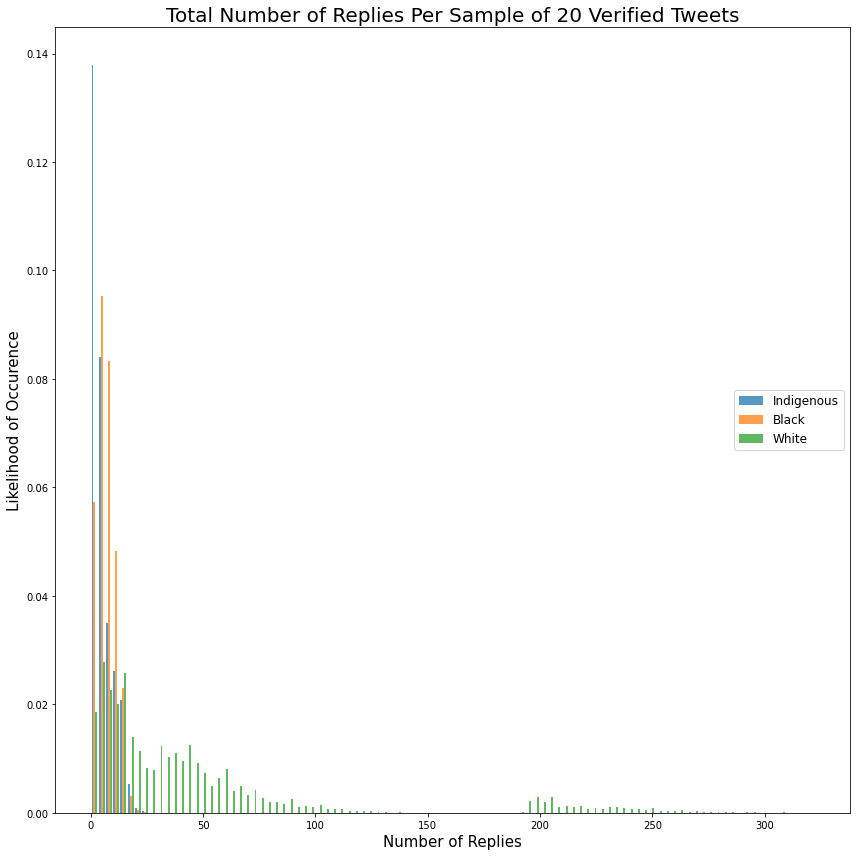

In [21]:
fig,ax = plt.subplots(1,1, figsize=(12,12))

ax.hist([ind_n_replies, bl_n_replies, wh_n_replies], 100, histtype='bar', alpha=.75, density=True, label=['Indigenous', 'Black', 'White'])#, stacked=True)
ax.legend(loc='right', fontsize=12)
ax.set_title('Total Number of Replies Per Sample of 20 Verified Tweets',fontsize=20)
ax.set_xlabel('Number of Replies',fontsize=15)
ax.set_ylabel('Likelihood of Occurence',fontsize=15)
fig.tight_layout()

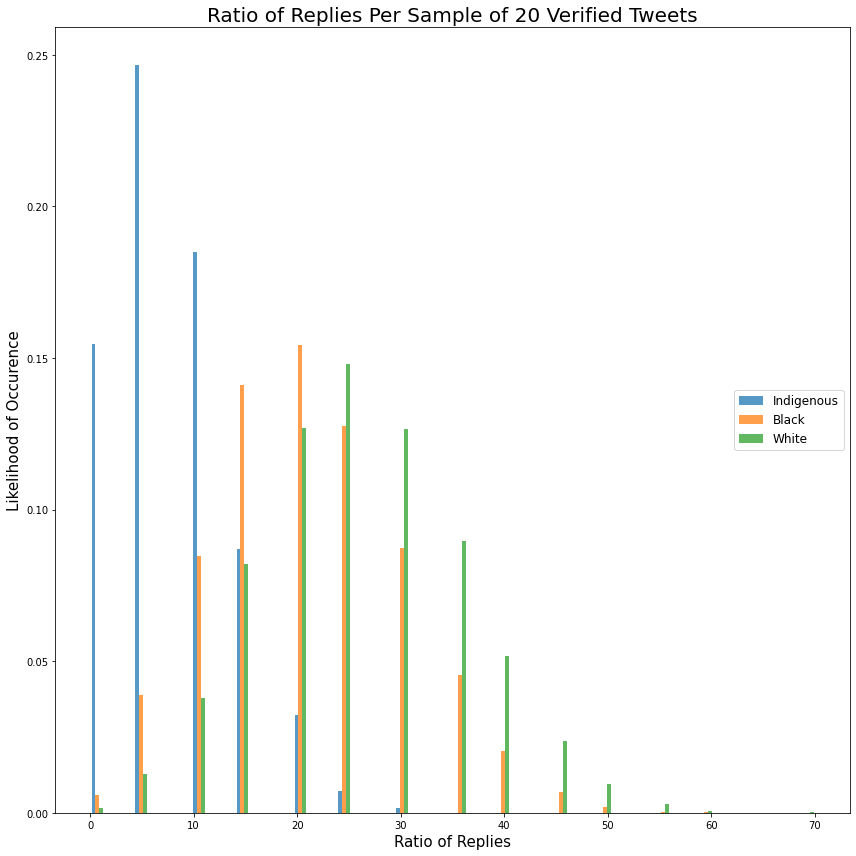

In [22]:
fig,ax = plt.subplots(1,1, figsize=(12,12))

ax.hist([ind_ratio, bl_ratio, wh_ratio], 50, histtype='bar', alpha=.75, density=True, label=['Indigenous', 'Black', 'White'])#, stacked=True)
ax.legend(loc='right', fontsize=12)
ax.set_title('Ratio of Replies Per Sample of 20 Verified Tweets',fontsize=20)
ax.set_xlabel('Ratio of Replies', fontsize=15)
ax.set_ylabel('Likelihood of Occurence', fontsize=15)
fig.tight_layout()

In [23]:
ind_rep_mean = np.mean(ind_n_replies)
bl_rep_mean = np.mean(bl_n_replies)
wh_rep_mean = np.mean(wh_n_replies)

ind_ratio_mean = np.mean(ind_ratio)
bl_ratio_mean = np.mean(bl_ratio)
wh_ratio_mean = np.mean(wh_ratio)

In [24]:
print(ind_rep_mean)
print(bl_rep_mean)
print(wh_rep_mean)

print(ind_ratio_mean)
print(bl_ratio_mean)
print(wh_ratio_mean)

4.8994
6.9945
46.846
7.359
20.816
26.14


## Linguistic Analysis



In [25]:
# Filter out handles
replies_all['tweet'] = replies_all['tweet'].str.replace(r"@[A-Za-z0-9_]+", '', flags=re.IGNORECASE)

/tmp/ipykernel_60663/3446802865.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  replies_all['tweet'] = replies_all['tweet'].str.replace(r"@[A-Za-z0-9_]+", '', flags=re.IGNORECASE)


In [26]:
nlp = spacy.load('en_core_web_lg')

i_tweets = replies_all.query('race == "I"')['tweet'].values
i_docs = list(nlp.pipe(i_tweets))

bl_tweets = replies_all.query('race == "B"')['tweet'].values
bl_docs = list(nlp.pipe(bl_tweets))

wh_tweets = replies_all.query('race == "W"')['tweet'].values
wh_docs = list(nlp.pipe(wh_tweets))

In [27]:
# Find the n most frequently used words
def freq_words(docs, n):
    words = [t.text for doc in docs for t in doc if (not t.is_stop and not t.is_punct and not t.is_space and t.ent_type_ != "PERSON")]
    word_freq = Counter(words)
    return(word_freq.most_common(n))

# Find the na most frequently used adjectives
def freq_adj(docs, n):
    adj = [t.text for doc in docs for t in doc if (not t.is_stop and not t.is_punct and not t.is_space and t.pos_ == "ADJ")]
    adj_freq = Counter(adj)
    return adj_freq.most_common(n)

Text(0.5, 1.0, 'White')

/jet/home/ahayseke/c4c_project/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128071 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/jet/home/ahayseke/c4c_project/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 128071 missing from current font.
  font.set_text(s, 0, flags=flags)


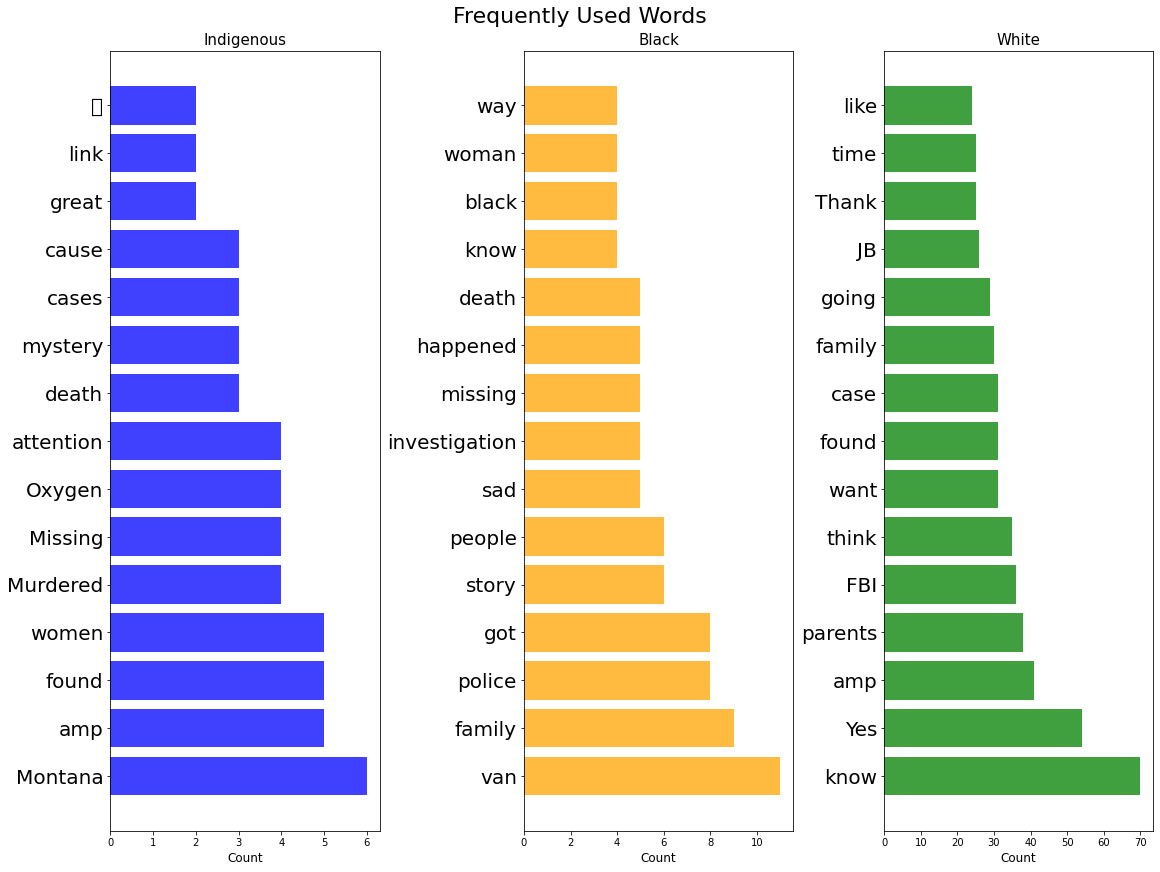

In [28]:
i_x,i_y = zip(*freq_words(i_docs, 15))
b_x,b_y = zip(*freq_words(bl_docs, 15))
wh_x,wh_y = zip(*freq_words(wh_docs, 15))

i_pos = np.arange(len(i_x))
bl_pos = np.arange(len(b_x))
wh_pos = np.arange(len(wh_x))

fig,ax = plt.subplots(1,3, figsize=(16,12), constrained_layout=True)
plt.suptitle('Frequently Used Words', fontsize=22)

ax[0].barh(i_pos, i_y, align='center', color='blue', alpha=.75)
ax[0].set_yticks(i_pos)
ax[0].set_yticklabels(i_x, fontsize=20)
ax[0].set_xlabel('Count', fontsize=12)
ax[0].set_title('Indigenous', fontsize=15)

ax[1].barh(bl_pos, b_y, align='center', color='orange', alpha=.75)
ax[1].set_yticks(bl_pos)
ax[1].set_yticklabels(b_x, fontsize=20)
ax[1].set_xlabel('Count', fontsize=12)
ax[1].set_title('Black', fontsize=15)

ax[2].barh(wh_pos, wh_y, align='center', color='green', alpha=.75)
ax[2].set_yticks(wh_pos)
ax[2].set_yticklabels(wh_x, fontsize=20)
ax[2].set_xlabel('Count', fontsize=12)
ax[2].set_title('White',fontsize=15)

Text(0.5, 1.0, 'White')

/jet/home/ahayseke/c4c_project/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/jet/home/ahayseke/c4c_project/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0, flags=flags)


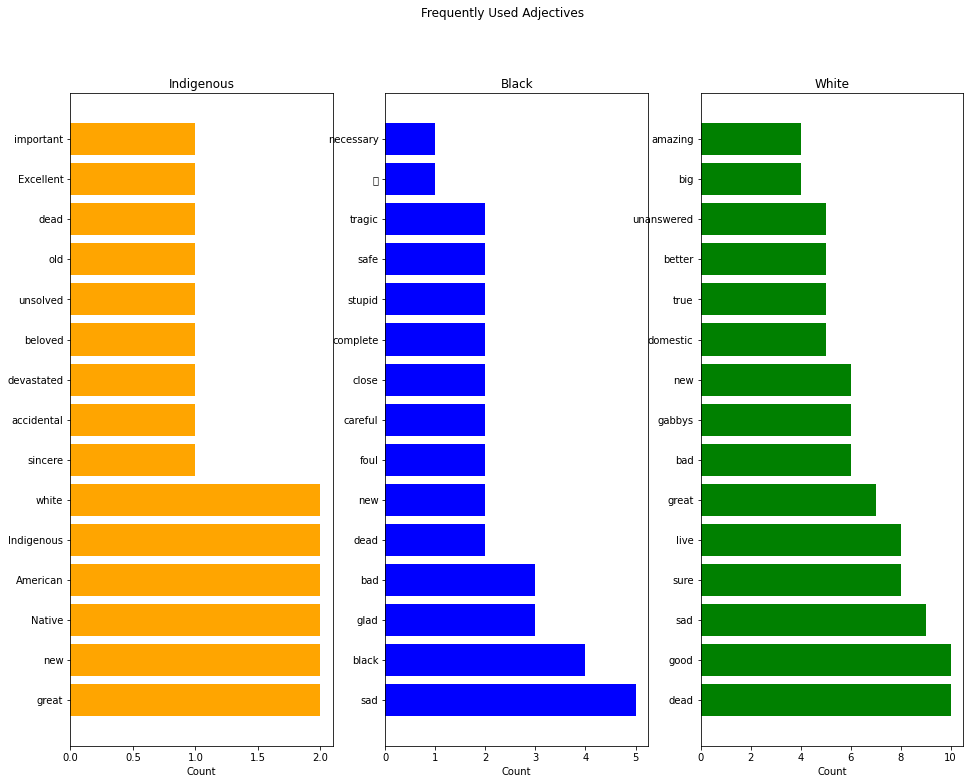

In [29]:
i_x,i_y = zip(*freq_adj(i_docs, 15))
b_x,b_y = zip(*freq_adj(bl_docs, 15))
wh_x,wh_y = zip(*freq_adj(wh_docs, 15))

i_pos = np.arange(len(i_x))
bl_pos = np.arange(len(b_x))
wh_pos = np.arange(len(wh_x))

fig,ax = plt.subplots(1,3, figsize=(16,12))
plt.suptitle('Frequently Used Adjectives')

ax[0].barh(i_pos, i_y, align='center', color='orange')
ax[0].set_yticks(i_pos)
ax[0].set_yticklabels(i_x)
ax[0].set_xlabel('Count')
ax[0].set_title('Indigenous')

ax[1].barh(bl_pos, b_y, align='center', color='blue')
ax[1].set_yticks(bl_pos)
ax[1].set_yticklabels(b_x)
ax[1].set_xlabel('Count')
ax[1].set_title('Black')

ax[2].barh(wh_pos, wh_y, align='center', color='green')
ax[2].set_yticks(wh_pos)
ax[2].set_yticklabels(wh_x)
ax[2].set_xlabel('Count')
ax[2].set_title('White')

## Emotion Analysis

In [30]:
ex_1 = "@Complex few cases make me angrier than this one"
ex_2 = "@NPR OMG!!! What horror did she go through???"
ex_3 = "@WWJ950 @955WYCD So glad to hear she is safe"

In [31]:
emotion_analyzer = EmotionAnalyzer(lang="en")


for ex in [ex_1, ex_2, ex_3]:
    ex_cleaned = preprocess_tweet(ex)
    print(emotion_analyzer.predict(ex_cleaned))

EmotionOutput(output=disgust, probas={disgust: 0.816, others: 0.158, anger: 0.012, sadness: 0.006, fear: 0.005, joy: 0.002, surprise: 0.001})
EmotionOutput(output=fear, probas={fear: 0.537, surprise: 0.412, others: 0.032, joy: 0.007, anger: 0.006, disgust: 0.003, sadness: 0.003})
EmotionOutput(output=joy, probas={joy: 0.953, others: 0.038, sadness: 0.002, anger: 0.002, surprise: 0.002, fear: 0.001, disgust: 0.001})


In [32]:
ind_emotion_output = []
bl_emotion_output = []
wh_emotion_output = []

for i in i_tweets:
    i_cleaned = preprocess_tweet(i)
    res = emotion_analyzer.predict(i)
    ind_emotion_output.append(res.output)
    
for bl in bl_tweets:
    bl_cleaned = preprocess_tweet(bl)
    res = emotion_analyzer.predict(bl)
    bl_emotion_output.append(res.output)
    
for wh in wh_tweets:
    wh_cleaned = preprocess_tweet(wh)
    res = emotion_analyzer.predict(wh)
    wh_emotion_output.append(res.output)

In [33]:
ind_count = Counter(ind_emotion_output)
bl_count = Counter(bl_emotion_output)
wh_count = Counter(wh_emotion_output)

In [34]:
ind_count 

Counter({'joy': 3, 'others': 16, 'sadness': 3, 'disgust': 7, 'anger': 1})

In [35]:
bl_count

Counter({'sadness': 19,
         'others': 48,
         'disgust': 29,
         'surprise': 3,
         'joy': 4,
         'fear': 2,
         'anger': 3})

In [36]:
wh_count

Counter({'others': 346,
         'disgust': 87,
         'joy': 78,
         'surprise': 4,
         'fear': 2,
         'anger': 15,
         'sadness': 18})

In [6]:
labels = ['Sadness', 'Others', 'Disgust', 'Joy', 'Surprise', 'Fear', 'Anger']
ind_data = [3, 16, 7, 3, 0, 0, 1]
bl_data = [19, 48, 29, 4, 3, 2, 3]
wh_data = [18, 346, 87, 78, 4, 2, 15]

ind_data = [(x/sum(ind_data)) for x in ind_data]
bl_data = [(x/sum(bl_data)) for x in bl_data]
wh_data = [(x/sum(wh_data)) for x in wh_data]

print(ind_data)

[0.1, 0.5333333333333333, 0.23333333333333334, 0.1, 0.0, 0.0, 0.03333333333333333]


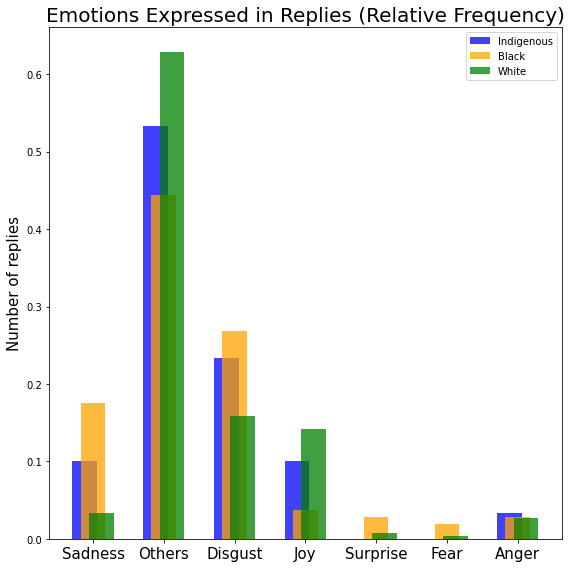

In [8]:

x_l = ['Sadness', 'Others', 'Disgust', 'Joy', 'Surprise', 'Fear', 'Anger']

x = np.arange(len(x_l))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,8))
rects1 = ax.bar(x-width/3, ind_data, width, color='blue', alpha=.75, label='Indigenous')
rects2 = ax.bar(x, bl_data, width, color='orange', alpha=.75, label='Black')
recs3 = ax.bar(x+width/3, wh_data, width, color='green', alpha=.75, label='White')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of replies', fontsize=15)
ax.set_title('Emotions Expressed in Replies (Relative Frequency)', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(x_l, fontsize=15)
ax.legend()

fig.tight_layout()
plt.show()